# note4

### 目的

- 実機でやりましょう
- 終わらせよう


In [31]:
from __future__ import annotations

from dataclasses import asdict, dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from src.utils.load_data import load_data, path_list
from src.utils.models import BuckConverterCell, GRUModel
from src.utils.plot_data import (
    plot_buck_gru_components_tail,
    plot_compare_tail,
    plot_param_learning_progress,
)
from src.utils.save_log import (
    create_result_dir,
    format_kv_lines,
    init_log,
    save_figure_to_log,
    save_text_output,
)

# 再現性
seed: int = 10
np.random.seed(seed)
torch.manual_seed(seed)

# 実行環境
# if torch.backends.mps.is_available():
#     device: torch.device = torch.device("mps")
# elif torch.cuda.is_available():
#     device: torch.device = torch.device("cuda")
# else:
#     device: torch.device = torch.device("cpu")
device: torch.device = torch.device("cpu")
print(f"device={device}")


device=cpu


In [32]:
keep_log: bool = True
keep_log: bool = False


@dataclass(frozen=True)
class Params:
    data_path: str = path_list.path3
    # --- 真値（シミュレーション生成用）---
    L_true: float = 223.6e-6
    C_true: float = 73.8e-6
    R_true: float = 5

    Vin: float = 10.0
    Vref: float = 5.0
    duty: float = Vref / Vin

    f_sw: float = 1e5
    T: float = 1.0 / f_sw

    # シミュレーションは長めに回して定常に入れたあと、学習には末尾だけを使う
    cycles: int = 1200
    samples_per_cycle: int = 200
    train_cycles: int = 10  # 末尾から何周期ぶんを学習に使うか

    # --- 擬似「計測」ノイズ ---
    noise_std_iL: float = 0.02  # [A]
    noise_std_vC: float = 0.02  # [V]

    # --- データ分割（時間方向に連続で分割）---
    train_ratio: float = 0.3
    valid_ratio: float = 0.3

    clipped_k: float = 2.0

    # --- Buck 学習（rollout）---
    L_init: float = 200e-6
    C_init: float = 73.8e-6
    R_init: float = 8.0

    # rollout は不安定になりやすいので 1 桁下げる
    lr_l: float = 5e-3
    lr_c: float = 1e-3
    lr_r: float = 2e-3

    epochs_buck: int = 8000
    win_len: int = 50
    batch_size: int = 256
    grad_clip_norm: float = 5.0

    # --- GRU（残差学習）---
    seq_length: int = 10
    gru_lr: float = 1e-3
    epochs_gru: int = 200


params = Params()

if keep_log:
    result_dir: Path = create_result_dir(
        "note4",
        base_dir="results/actual",
        config_dict=asdict(params),
    )
    init_log(result_dir, "actual_machine_notebooks/note4/note.ipynb")
    save_text_output(result_dir, text=format_kv_lines(asdict(params)), title="Params")
    print(f"log_dir={result_dir}")


# BuckConverterCell


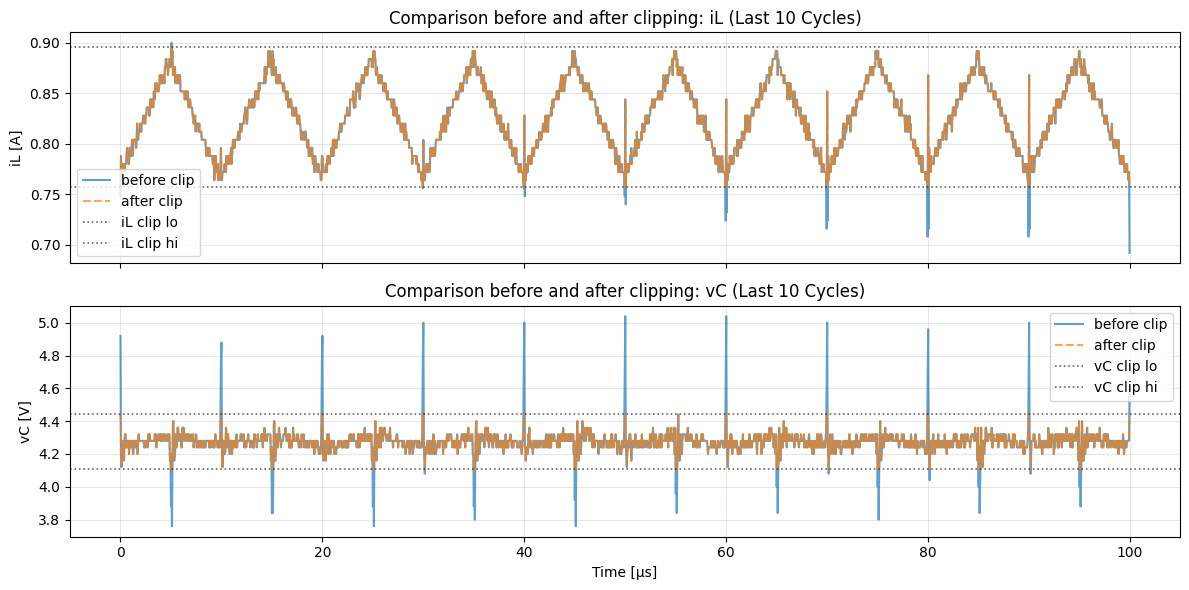

In [33]:
t_raw, iL_raw, vC_raw = load_data(
    path=params.data_path,
    downsample_step=1,  # ダウンスケールしない
    T=params.T,
    cycles=params.train_cycles,
    iL_label="CH2",
    vC_label="CH1",
)

# ダウンサンプリング
downsample_step = len(t_raw) // (params.samples_per_cycle * params.train_cycles)
t_meas: np.ndarray = t_raw[::downsample_step]
iL_meas: np.ndarray = iL_raw[::downsample_step]
vC_meas: np.ndarray = vC_raw[::downsample_step]


# ノイズのクリッピング
def clip_by_mean_std(x: np.ndarray, k: float) -> tuple[np.ndarray, float, float]:
    mu = float(np.mean(x))
    std = float(np.std(x))
    lo = mu - k * std
    hi = mu + k * std
    x_clipped = np.clip(x, lo, hi)
    return x_clipped.astype(x.dtype, copy=False), lo, hi


iL_clipped, iL_lo, iL_hi = clip_by_mean_std(iL_meas, k=params.clipped_k)
vC_clipped, vC_lo, vC_hi = clip_by_mean_std(vC_meas, k=params.clipped_k)

# プロット
fig, ax = plot_compare_tail(
    t_meas,
    iL_meas,
    vC_meas,
    "before clip",
    t_meas,
    iL_clipped,
    vC_clipped,
    "after clip",
    params.T,
    title="Comparison before and after clipping",
    iL_range=(iL_lo, iL_hi),
    vC_range=(vC_lo, vC_hi),
)

if keep_log:
    save_figure_to_log(fig, "compare_tail.png", result_dir)

In [34]:
# スイッチング信号
duty_phase = (t_meas[:-1] % params.T) / params.T
u = (duty_phase < params.duty).astype(int)

# 入力電圧
vs = np.ones(len(t_meas) - 1) * params.Vin


In [35]:
def rollout_cell(
    cell: BuckConverterCell,
    h0: torch.Tensor,  # [B,2]
    x_seq: torch.Tensor,  # [B,T,3]
) -> torch.Tensor:
    """BuckConverterCell を逐次適用して roll-out する（学習用）"""
    if h0.ndim != 2 or h0.shape[1] != 2:
        raise ValueError("h0 must be [B,2]")
    if x_seq.ndim != 3 or x_seq.shape[2] != 3:
        raise ValueError("x_seq must be [B,T,3]")

    # B: int = int(h0.shape[0])
    T: int = int(x_seq.shape[1])

    h: torch.Tensor = h0
    preds: list[torch.Tensor] = []

    for t in range(T):
        h = cell(h, x_seq[:, t, :])
        preds.append(h)

    # [B,T,2]（各ステップの「次状態」）
    return torch.stack(preds, dim=1)


def make_windows(
    h_steps: torch.Tensor,  # [N,2]
    x_steps: torch.Tensor,  # [N,3]
    win_len: int,
    batch_size: int,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """連続系列から window をサンプリング

    - h0: [B,2]（開始状態）
    - x:  [B,win_len,3]（入力列）
    - y:  [B,win_len,2]（真の次状態列）
    """
    if win_len <= 0:
        raise ValueError("win_len must be positive")

    N_local: int = int(h_steps.shape[0])
    max_start: int = N_local - win_len - 1
    if max_start <= 0:
        raise ValueError("series is too short for the given win_len")

    # [0, max_start] から開始点を選ぶ（i=開始状態、教師は i+1..i+win_len）
    start_idx = torch.randint(
        low=0, high=max_start, size=(batch_size,), device=h_steps.device
    )

    h0 = h_steps[start_idx]  # [B,2]

    # x: i..i+win_len-1
    x = torch.stack([x_steps[i : i + win_len] for i in start_idx.tolist()], dim=0)

    # y: (i+1)..(i+win_len)
    y = torch.stack(
        [h_steps[i + 1 : i + 1 + win_len] for i in start_idx.tolist()], dim=0
    )

    return h0, x, y


def rollout_mse_loss(
    cell: BuckConverterCell,
    h0: torch.Tensor,
    x_win: torch.Tensor,
    y_win: torch.Tensor,
) -> torch.Tensor:
    """window rollout の MSE 損失"""
    pred = rollout_cell(cell, h0=h0, x_seq=x_win)  # [B,win_len,2]
    return nn.functional.mse_loss(pred, y_win)


@torch.no_grad()
def rollout_full_series(
    cell: BuckConverterCell,
    h0_1x2: torch.Tensor,  # [1,2]
    x_steps: torch.Tensor,  # [N,3]
) -> torch.Tensor:
    """系列全体を roll-out（推論・評価用）

    Returns:
        h_series_pred: [N+1,2]
    """
    if h0_1x2.shape != (1, 2):
        raise ValueError("h0_1x2 must be shape (1,2)")

    h_list: list[torch.Tensor] = [h0_1x2]
    h_cur: torch.Tensor = h0_1x2

    for k in range(int(x_steps.shape[0])):
        h_cur = cell(h_cur, x_steps[k : k + 1])
        h_list.append(h_cur)

    return torch.cat(h_list, dim=0)


In [36]:
# --- 連続区間で train/valid/test に分割（状態は N+1, 入力は N）---
N: int = int(params.samples_per_cycle * params.train_cycles)
train_steps: int = int(N * params.train_ratio)
valid_steps: int = int(N * params.valid_ratio)
test_steps: int = N - train_steps - valid_steps

dt = t_meas[1:] - t_meas[:-1]
dt_tensor = torch.tensor(dt, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
vs_tensor = torch.tensor(vs, dtype=torch.float32)
iL_clipped_tensor = torch.tensor(iL_clipped, dtype=torch.float32)
vC_clipped_tensor = torch.tensor(vC_clipped, dtype=torch.float32)
h_meas_steps = torch.stack([iL_clipped_tensor, vC_clipped_tensor], dim=1)
x_steps = torch.stack([vs_tensor, u_tensor, dt_tensor], dim=1)

h_meas_train_steps = h_meas_steps[:train_steps]
h_meas_valid_steps = h_meas_steps[train_steps : train_steps + valid_steps]
h_meas_test_steps = h_meas_steps[train_steps + valid_steps : -1]

x_train = x_steps[:train_steps]
x_valid = x_steps[train_steps : train_steps + valid_steps]
x_test = x_steps[train_steps + valid_steps :]

h_meas_train_next = h_meas_steps[1 : train_steps + 1]
h_meas_valid_next = h_meas_steps[train_steps + 1 : train_steps + valid_steps + 1]
h_meas_test_next = h_meas_steps[train_steps + valid_steps + 1 :]

print(h_meas_train_steps.shape)
print(h_meas_valid_steps.shape)
print(h_meas_test_steps.shape)
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(h_meas_train_next.shape)
print(h_meas_valid_next.shape)
print(h_meas_test_next.shape)


torch.Size([600, 2])
torch.Size([600, 2])
torch.Size([800, 2])
torch.Size([600, 3])
torch.Size([600, 3])
torch.Size([800, 3])
torch.Size([600, 2])
torch.Size([600, 2])
torch.Size([800, 2])


In [37]:
# --- BuckConverterCell を rollout 損失で学習 ---
cell = BuckConverterCell(
    L_init=params.L_init, C_init=params.C_init, R_init=params.R_init
).to(device)

optimizer = optim.Adam(
    [
        {"params": [cell.log_L], "lr": params.lr_l},
        {"params": [cell.log_C], "lr": params.lr_c},
        {"params": [cell.log_R], "lr": params.lr_r},
    ]
)

loss_history: dict[str, list[float]] = {
    "train_roll": [],
    "valid_roll": [],
    "train_tf": [],
    "valid_tf": [],
}
param_history: dict[str, list[float]] = {"L": [], "C": [], "R": []}


def teacher_forcing_loss(
    h_steps: torch.Tensor, x_steps: torch.Tensor, h_next: torch.Tensor
) -> torch.Tensor:
    pred_next = cell(h_steps, x_steps)
    return nn.functional.mse_loss(pred_next, h_next)


@torch.no_grad()
def estimate_rollout_loss(
    h_steps: torch.Tensor,
    x_steps: torch.Tensor,
    win_len: int,
    n_batches: int,
    batch_size: int,
) -> float:
    cell.eval()
    losses: list[float] = []
    for _ in range(n_batches):
        h0_b, x_b, y_b = make_windows(
            h_steps, x_steps, win_len=win_len, batch_size=batch_size
        )
        loss = rollout_mse_loss(cell, h0=h0_b, x_win=x_b, y_win=y_b)
        losses.append(float(loss.detach().cpu().item()))
    return float(np.mean(losses))


log_every: int = 200
valid_batches: int = 10

for epoch in range(1, int(params.epochs_buck) + 1):
    cell.train()
    optimizer.zero_grad(set_to_none=True)

    h0_b, x_b, y_b = make_windows(
        h_meas_train_steps,
        x_train,
        win_len=int(params.win_len),
        batch_size=int(params.batch_size),
    )

    loss_roll = rollout_mse_loss(cell, h0=h0_b, x_win=x_b, y_win=y_b)
    loss_roll.backward()

    # 勾配クリップ（rollout 学習の発散対策）
    nn.utils.clip_grad_norm_(cell.parameters(), max_norm=float(params.grad_clip_norm))
    optimizer.step()

    if epoch % log_every == 0 or epoch == 1:
        cell.eval()
        with torch.no_grad():
            train_tf = float(
                teacher_forcing_loss(h_meas_train_steps, x_train, h_meas_train_next)
                .cpu()
                .item()
            )
            valid_tf = float(
                teacher_forcing_loss(h_meas_valid_steps, x_valid, h_meas_valid_next)
                .cpu()
                .item()
            )
            train_roll = estimate_rollout_loss(
                h_meas_train_steps,
                x_train,
                win_len=int(params.win_len),
                n_batches=valid_batches,
                batch_size=int(params.batch_size),
            )
            valid_roll = estimate_rollout_loss(
                h_meas_valid_steps,
                x_valid,
                win_len=int(params.win_len),
                n_batches=valid_batches,
                batch_size=int(params.batch_size),
            )

        loss_history["train_tf"].append(train_tf)
        loss_history["valid_tf"].append(valid_tf)
        loss_history["train_roll"].append(train_roll)
        loss_history["valid_roll"].append(valid_roll)

        L_est = float(cell.log_L.exp().detach().cpu().item())
        C_est = float(cell.log_C.exp().detach().cpu().item())
        R_est = float(cell.log_R.exp().detach().cpu().item())
        param_history["L"].append(L_est)
        param_history["C"].append(C_est)
        param_history["R"].append(R_est)

        print(
            f"epoch={epoch:5d} "
            f"roll(train/valid)={train_roll:.3e}/{valid_roll:.3e} "
            f"tf(train/valid)={train_tf:.3e}/{valid_tf:.3e} "
            f"L={L_est * 1e6:.1f}uH C={C_est * 1e6:.1f}uF R={R_est:.2f}ohm"
        )

# 学習後の推定値
L_hat: float = float(cell.log_L.exp().detach().cpu().item())
C_hat: float = float(cell.log_C.exp().detach().cpu().item())
R_hat: float = float(cell.log_R.exp().detach().cpu().item())
print(f"L_hat={L_hat:.6e}, C_hat={C_hat:.6e}, R_hat={R_hat:.6e}")

if keep_log:
    save_text_output(
        result_dir,
        text=f"L_hat={L_hat:.6e}\nC_hat={C_hat:.6e}\nR_hat={R_hat:.6e}\n",
        title="Buck 推定値",
    )


epoch=    1 roll(train/valid)=2.517e-03/2.429e-03 tf(train/valid)=1.327e-03/1.428e-03 L=201.0uH C=73.9uF R=7.98ohm
epoch=  200 roll(train/valid)=2.431e-03/2.450e-03 tf(train/valid)=1.327e-03/1.428e-03 L=223.8uH C=79.9uF R=5.84ohm
epoch=  400 roll(train/valid)=2.428e-03/2.426e-03 tf(train/valid)=1.327e-03/1.428e-03 L=225.1uH C=72.0uF R=5.02ohm
epoch=  600 roll(train/valid)=2.491e-03/2.514e-03 tf(train/valid)=1.327e-03/1.428e-03 L=225.2uH C=61.0uF R=5.08ohm
epoch=  800 roll(train/valid)=2.435e-03/2.383e-03 tf(train/valid)=1.327e-03/1.428e-03 L=225.0uH C=50.1uF R=5.17ohm
epoch= 1000 roll(train/valid)=2.453e-03/2.493e-03 tf(train/valid)=1.327e-03/1.428e-03 L=224.7uH C=40.0uF R=5.11ohm
epoch= 1200 roll(train/valid)=2.403e-03/2.456e-03 tf(train/valid)=1.326e-03/1.428e-03 L=223.8uH C=31.1uF R=5.06ohm
epoch= 1400 roll(train/valid)=2.445e-03/2.429e-03 tf(train/valid)=1.326e-03/1.427e-03 L=223.9uH C=23.4uF R=5.03ohm
epoch= 1600 roll(train/valid)=2.331e-03/2.419e-03 tf(train/valid)=1.326e-03/1.42

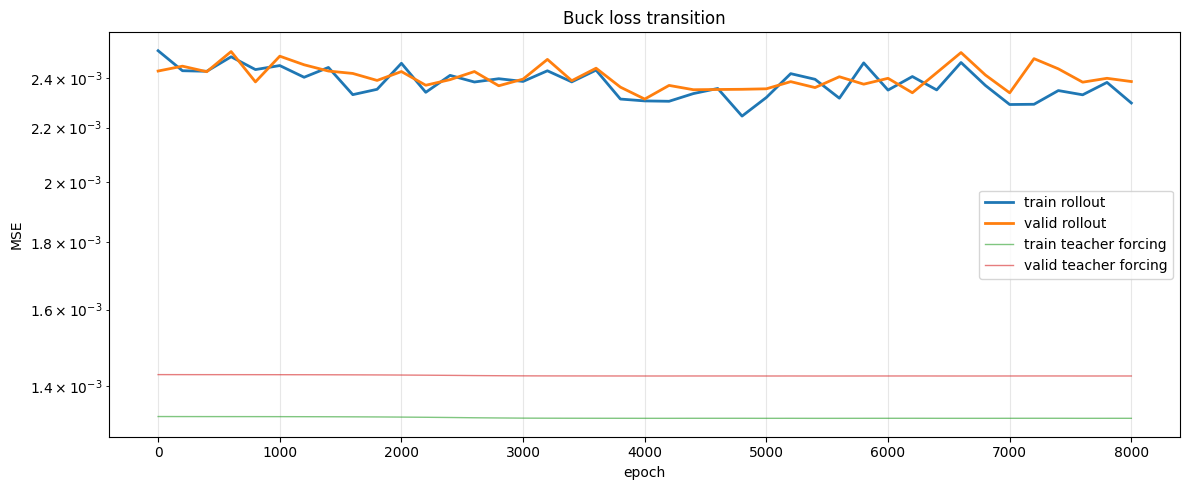

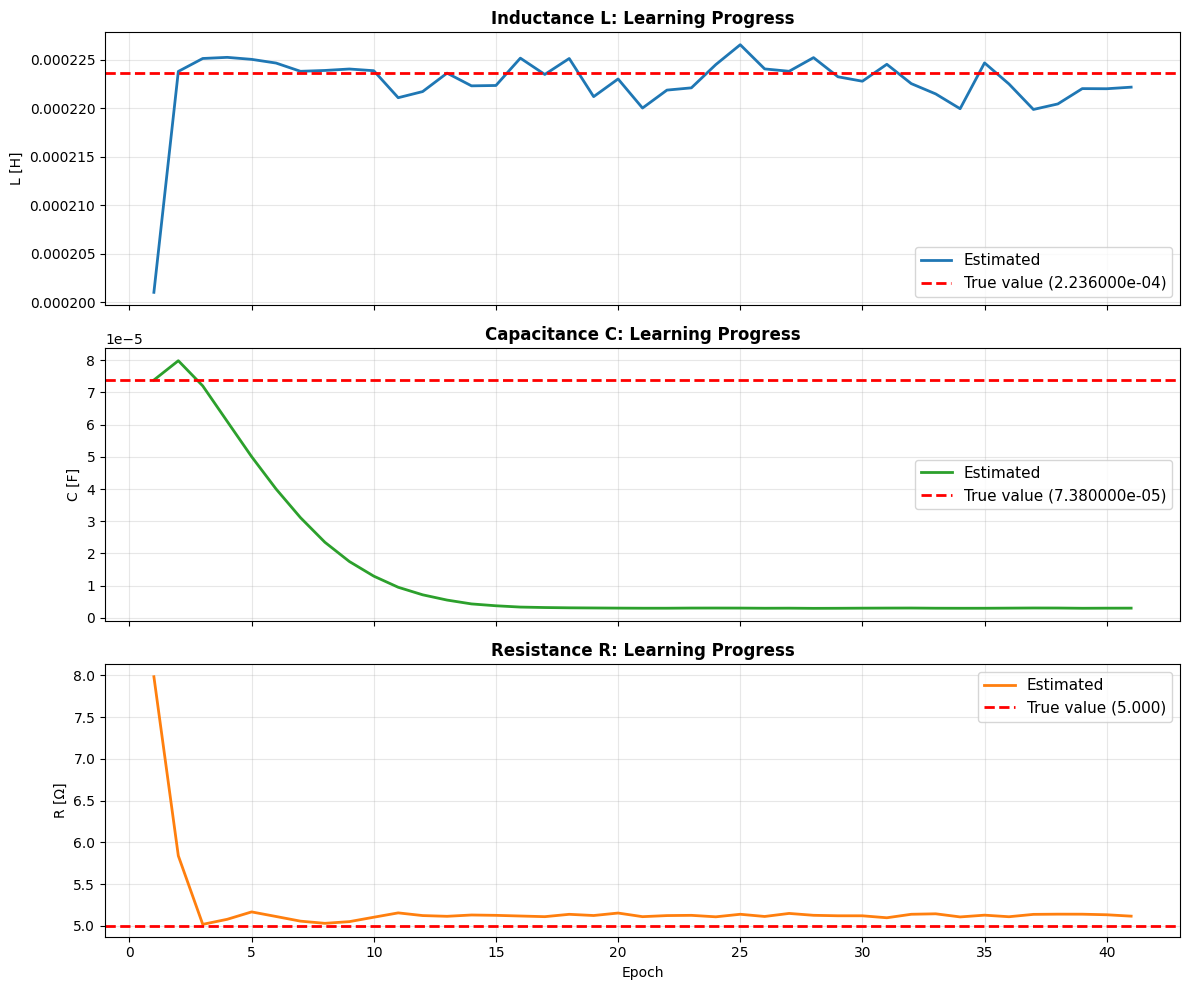

In [38]:
# --- 学習の可視化（損失とパラメータ）---
fig_loss, ax = plt.subplots(1, 1, figsize=(12, 5))

x_axis = np.arange(len(loss_history["train_roll"])) * log_every
ax.plot(x_axis, loss_history["train_roll"], label="train rollout", linewidth=2)
ax.plot(x_axis, loss_history["valid_roll"], label="valid rollout", linewidth=2)
ax.plot(
    x_axis,
    loss_history["train_tf"],
    label="train teacher forcing",
    linewidth=1,
    alpha=0.6,
)
ax.plot(
    x_axis,
    loss_history["valid_tf"],
    label="valid teacher forcing",
    linewidth=1,
    alpha=0.6,
)
ax.set_yscale("log")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title("Buck loss transition")
plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(fig_loss, "buck_loss_transition", result_dir, "Buck 損失遷移")

fig_param, _ = plot_param_learning_progress(
    param_history=param_history,
    L_true=float(params.L_true),
    C_true=float(params.C_true),
    R_true=float(params.R_true),
    epochs=len(param_history["L"]),
)
plt.show()

if keep_log:
    save_figure_to_log(
        fig_param, "buck_param_learning", result_dir, "Buck パラメータ推定の推移"
    )


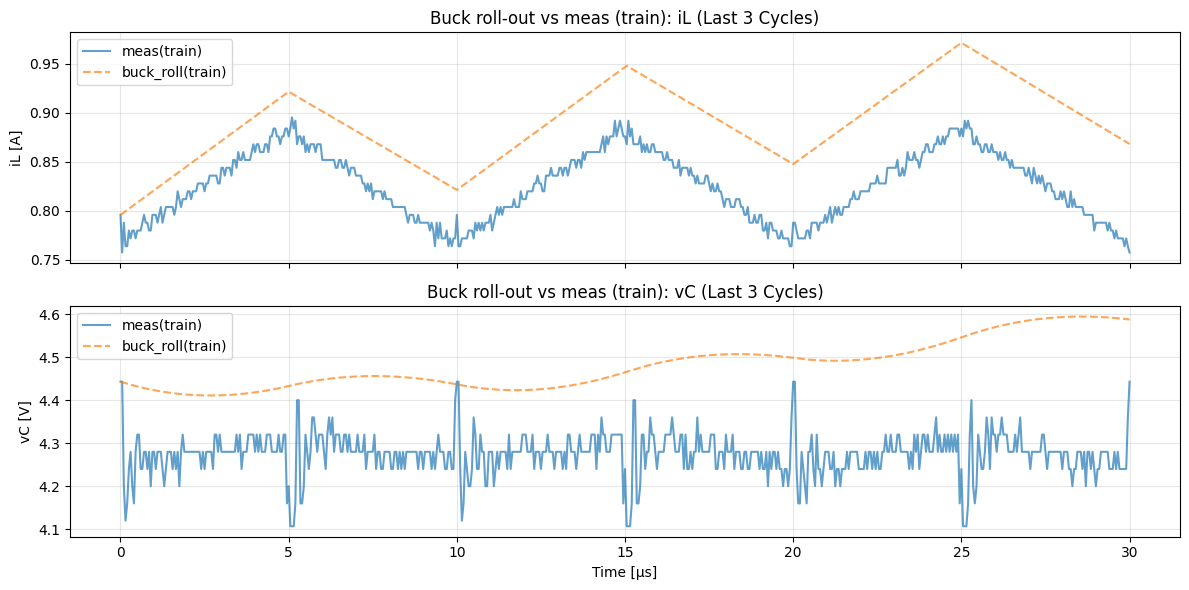

train: rollout MSE(steps)=2.664044e-02


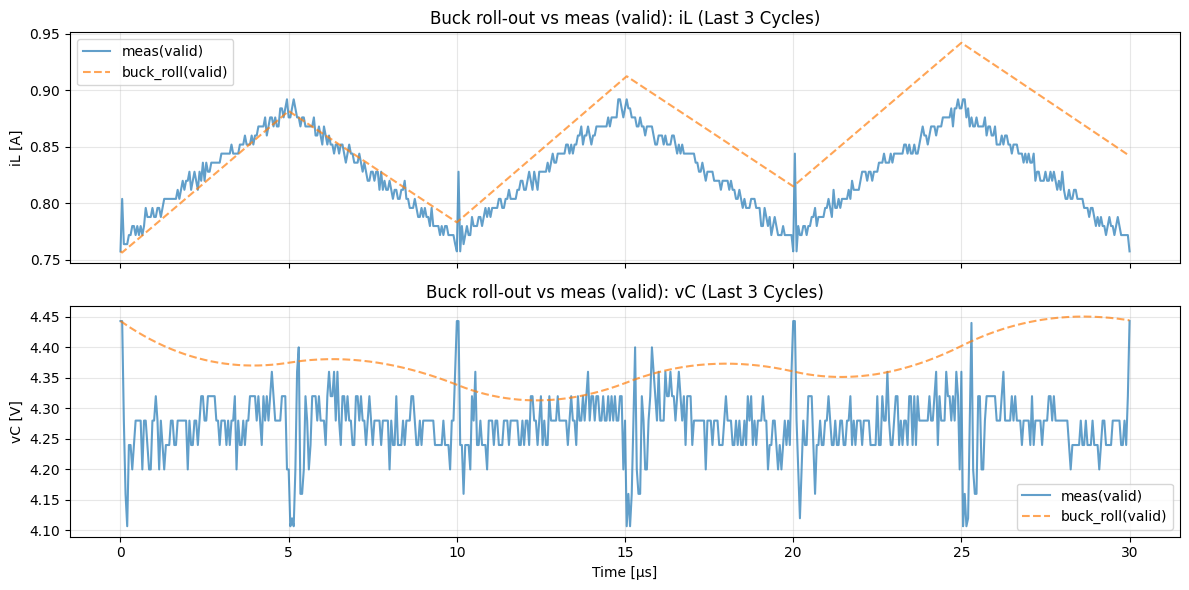

valid: rollout MSE(steps)=7.888710e-03


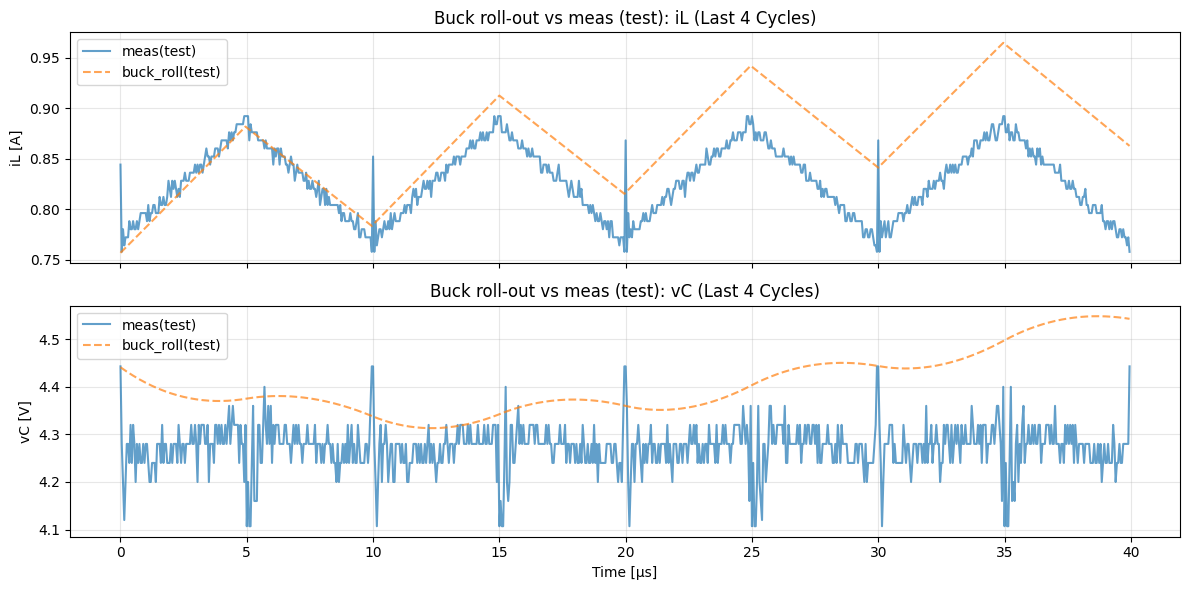

test: rollout MSE(steps)=1.323325e-02


In [39]:
# --- Buck: 区間ごとに full roll-out して比較（train/valid/test）---
@torch.no_grad()
def rollout_and_compare(
    split_name: str,
    t_series: np.ndarray,  # [N+1]
    h_meas_series_local: torch.Tensor,  # [N+1,2]
    x_steps_local: torch.Tensor,  # [N,3]
    N_cycles: float = 4.0,
) -> torch.Tensor:
    cell.eval()
    h0 = h_meas_series_local[:1]  # [1,2]
    h_pred_series = rollout_full_series(
        cell, h0_1x2=h0, x_steps=x_steps_local
    )  # [N+1,2]

    h_meas_np = h_meas_series_local.detach().cpu().numpy()
    h_pred_np = h_pred_series.detach().cpu().numpy()

    fig, _ = plot_compare_tail(
        t1=t_series,
        iL1=h_meas_np[:, 0],
        vC1=h_meas_np[:, 1],
        label1=f"meas({split_name})",
        t2=t_series,
        iL2=h_pred_np[:, 0],
        vC2=h_pred_np[:, 1],
        label2=f"buck_roll({split_name})",
        T=float(params.T),
        N_cycles=float(N_cycles),
        title=f"Buck roll-out vs meas ({split_name})",
    )
    plt.show()

    if keep_log:
        save_figure_to_log(
            fig,
            f"buck_rollout_{split_name}",
            result_dir,
            f"Buck rollout比較({split_name})",
        )

    # rollout MSE（steps で評価）
    mse_steps = (
        nn.functional.mse_loss(h_pred_series[:-1], h_meas_series_local[:-1])
        .detach()
        .cpu()
        .item()
    )
    print(f"{split_name}: rollout MSE(steps)={mse_steps:.6e}")
    return h_pred_series


# series の切り出し（x_* は steps 長）
t_train_series = t_meas[: train_steps + 1]
t_valid_series = t_meas[train_steps : train_steps + valid_steps + 1]
t_test_series = t_meas[train_steps + valid_steps :]

h_meas_train_series = h_meas_steps[: train_steps + 1]
h_meas_valid_series = h_meas_steps[train_steps : train_steps + valid_steps + 1]
h_meas_test_series = h_meas_steps[train_steps + valid_steps :]


h_buck_train_series = rollout_and_compare(
    "train", t_train_series, h_meas_train_series, x_train, N_cycles=3
)
h_buck_valid_series = rollout_and_compare(
    "valid", t_valid_series, h_meas_valid_series, x_valid, N_cycles=3
)
h_buck_test_series = rollout_and_compare(
    "test", t_test_series, h_meas_test_series, x_test, N_cycles=4
)


In [40]:
# --- GRU 用: 無次元化スケールの定義（特に dt）---
@dataclass(frozen=True)
class Scales:
    Vin: float
    Vref: float
    I_base: float
    f_sw: float


# I_base は train 区間の電流スケール（0割防止）
iL_train_np = h_meas_train_series[:, 0].detach().cpu().numpy()
I_base = float(np.maximum(np.mean(np.abs(iL_train_np)), 1e-3))

scales = Scales(
    Vin=float(params.Vin),
    Vref=float(params.Vref),
    I_base=I_base,
    f_sw=float(params.f_sw),
)
print(scales)


def scale_h(h: torch.Tensor, scales_: Scales) -> torch.Tensor:
    """h=[iL,vC] を無次元化"""
    out = torch.empty_like(h)
    out[:, 0] = h[:, 0] / float(scales_.I_base)
    out[:, 1] = h[:, 1] / float(scales_.Vref)
    return out


def scale_x(x: torch.Tensor, scales_: Scales) -> torch.Tensor:
    """x=[vs,u,dt] を無次元化（uはそのまま）"""
    out = torch.empty_like(x)
    out[:, 0] = x[:, 0] / float(scales_.Vin)
    out[:, 1] = x[:, 1]
    out[:, 2] = x[:, 2] * float(scales_.f_sw)  # dt/T 相当
    return out


def scale_noise(noise: torch.Tensor, scales_: Scales) -> torch.Tensor:
    """noise=[iL_noise,vC_noise] を無次元化"""
    out = torch.empty_like(noise)
    out[:, 0] = noise[:, 0] / float(scales_.I_base)
    out[:, 1] = noise[:, 1] / float(scales_.Vref)
    return out


Scales(Vin=10.0, Vref=5.0, I_base=0.8256683349609375, f_sw=100000.0)


In [41]:
# --- GRU 用データ作成（残差 = meas - buck_rollout）---
# steps に揃える（長さ N_split）
h_buck_train_steps = h_buck_train_series[:-1]
h_buck_valid_steps = h_buck_valid_series[:-1]
h_buck_test_steps = h_buck_test_series[:-1]

# 区間・長さチェック（steps長で一致していること）
assert h_meas_train_steps.shape == h_buck_train_steps.shape
assert h_meas_valid_steps.shape == h_buck_valid_steps.shape
assert h_meas_test_steps.shape == h_buck_test_steps.shape
assert x_train.shape[0] == h_meas_train_steps.shape[0]
assert x_valid.shape[0] == h_meas_valid_steps.shape[0]
assert x_test.shape[0] == h_meas_test_steps.shape[0]

# 残差（定義は維持）
noise_train_steps = h_meas_train_steps - h_buck_train_steps
noise_valid_steps = h_meas_valid_steps - h_buck_valid_steps
noise_test_steps = h_meas_test_steps - h_buck_test_steps

# 無次元化（既存方針を維持）
h_train_scaled = scale_h(h_meas_train_steps, scales)
x_train_scaled = scale_x(x_train, scales)
noise_train_scaled = scale_noise(noise_train_steps, scales)

h_valid_scaled = scale_h(h_meas_valid_steps, scales)
x_valid_scaled = scale_x(x_valid, scales)
noise_valid_scaled = scale_noise(noise_valid_steps, scales)

h_test_scaled = scale_h(h_meas_test_steps, scales)
x_test_scaled = scale_x(x_test, scales)
noise_test_scaled = scale_noise(noise_test_steps, scales)


def standardize_noise(
    noise_scaled: torch.Tensor, mean: torch.Tensor, std: torch.Tensor
) -> torch.Tensor:
    """noise_scaled を z-score 標準化する（mean/std は train 由来）"""
    return (noise_scaled - mean) / std


@torch.no_grad()
def destandardize_noise(
    noise_z: torch.Tensor, mean: torch.Tensor, std: torch.Tensor
) -> torch.Tensor:
    """z-score 空間の noise を noise_scaled に戻す"""
    return noise_z * std + mean


# --- z-score（train 区間のみで統計量を計算）---
noise_mean: torch.Tensor = noise_train_scaled.mean(dim=0)  # [2]
noise_std: torch.Tensor = noise_train_scaled.std(dim=0).clamp_min(1e-8)  # [2]

noise_train_z = standardize_noise(noise_train_scaled, noise_mean, noise_std)
noise_valid_z = standardize_noise(noise_valid_scaled, noise_mean, noise_std)
noise_test_z = standardize_noise(noise_test_scaled, noise_mean, noise_std)

# 統計チェック（train）
mean_z = noise_train_z.mean(dim=0)
std_z = noise_train_z.std(dim=0)
print(f"noise_mean(scaled)={noise_mean.detach().cpu().numpy()}")
print(f"noise_std(scaled) ={noise_std.detach().cpu().numpy()}")
print(f"noise_train_z mean={mean_z.detach().cpu().numpy()}")
print(f"noise_train_z std ={std_z.detach().cpu().numpy()}")

if keep_log:
    save_text_output(
        result_dir,
        text=(
            "[GRU noise z-score stats]\n"
            f"noise_mean_scaled={noise_mean.detach().cpu().numpy()}\n"
            f"noise_std_scaled ={noise_std.detach().cpu().numpy()}\n"
            f"noise_train_z_mean={mean_z.detach().cpu().numpy()}\n"
            f"noise_train_z_std ={std_z.detach().cpu().numpy()}\n"
        ),
        title="GRU noise z-score stats",
    )


def create_sequences_scaled(
    h_scaled: torch.Tensor,  # [N,2]
    x_scaled: torch.Tensor,  # [N,3]
    noise_z: torch.Tensor,  # [N,2]
    seq_len: int,
) -> tuple[torch.Tensor, torch.Tensor]:
    """GRU 入力系列を作成（noise は z-score 空間）

    入力特徴量（各時刻）: [iL, vC, vs, u, dt, iL_noise_prev(z), vC_noise_prev(z)](7次元)
    出力（教師）: 次時刻の noise_z [iL_noise_z, vC_noise_z]
    """
    if seq_len <= 0:
        raise ValueError("seq_len must be positive")

    N_local = int(h_scaled.shape[0])
    if N_local <= seq_len:
        raise ValueError("series is too short for seq_len")

    X_list: list[torch.Tensor] = []
    y_list: list[torch.Tensor] = []

    for i in range(N_local - seq_len):
        seq_frames: list[torch.Tensor] = []
        for j in range(seq_len):
            idx = i + j
            state_and_in = torch.cat([h_scaled[idx], x_scaled[idx]], dim=0)  # 5
            noise_prev = (
                noise_z[idx - 1] if idx > 0 else torch.zeros(2, device=h_scaled.device)
            )
            frame = torch.cat([state_and_in, noise_prev], dim=0)  # 7
            seq_frames.append(frame)

        X_list.append(torch.stack(seq_frames, dim=0))
        y_list.append(noise_z[i + seq_len])

    return torch.stack(X_list, dim=0), torch.stack(y_list, dim=0)


X_train_seq, y_train_seq = create_sequences_scaled(
    h_train_scaled, x_train_scaled, noise_train_z, seq_len=int(params.seq_length)
)
X_valid_seq, y_valid_seq = create_sequences_scaled(
    h_valid_scaled, x_valid_scaled, noise_valid_z, seq_len=int(params.seq_length)
)
X_test_seq, y_test_seq = create_sequences_scaled(
    h_test_scaled, x_test_scaled, noise_test_z, seq_len=int(params.seq_length)
)

print(f"X_train_seq={tuple(X_train_seq.shape)} y_train_seq={tuple(y_train_seq.shape)}")
print(f"X_valid_seq={tuple(X_valid_seq.shape)} y_valid_seq={tuple(y_valid_seq.shape)}")
print(f"X_test_seq={tuple(X_test_seq.shape)} y_test_seq={tuple(y_test_seq.shape)}")
print(f"input_size={int(X_train_seq.shape[2])}")


noise_mean(scaled)=[-0.07820721 -0.04143505]
noise_std(scaled) =[0.02677236 0.01511462]
noise_train_z mean=[ 0.0000000e+00 -3.6557516e-08]
noise_train_z std =[1. 1.]
X_train_seq=(590, 10, 7) y_train_seq=(590, 2)
X_valid_seq=(590, 10, 7) y_valid_seq=(590, 2)
X_test_seq=(790, 10, 7) y_test_seq=(790, 2)
input_size=7


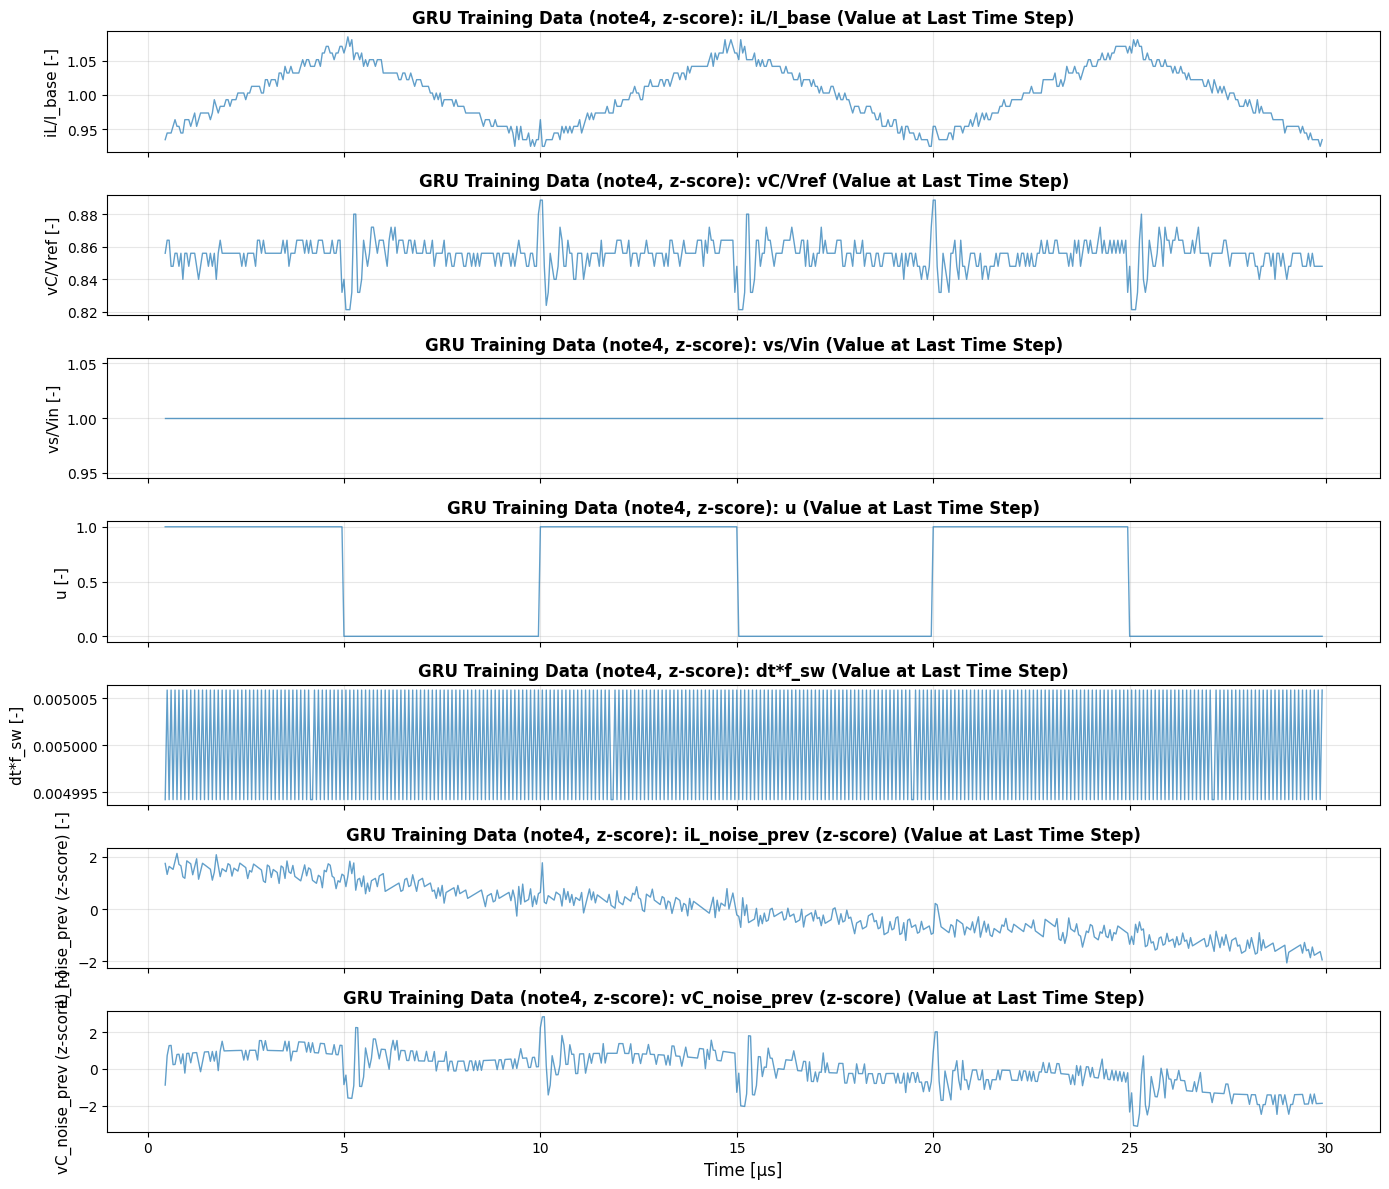

In [42]:
# --- GRU学習データ（入力特徴量）を全体表示（note3と同様）---
# X_train_seq: [N_samples, seq_len, 7]（h/xは無次元化、noiseは z-score）
X_train_seq_np: np.ndarray = X_train_seq.detach().cpu().numpy()

# 入力特徴量名（note4のスケーリング仕様に合わせて表記）
feature_names: list[str] = [
    "iL/I_base",
    "vC/Vref",
    "vs/Vin",
    "u",
    "dt*f_sw",
    "iL_noise_prev (z-score)",
    "vC_noise_prev (z-score)",
]
feature_units: list[str] = ["[-]", "[-]", "[-]", "[-]", "[-]", "[-]", "[-]"]

# 各系列サンプルの「最後の時刻」の特徴量を並べる（note3と同じ）
last_timestep_features: np.ndarray = X_train_seq_np[:, -1, :]  # [N_samples, 7]

# time_axis（最後時刻に対応させる）
# train区間の時刻は t_train_series: [train_steps+1]
# サンプルiの最後時刻は (i+seq_len-1)番目のstep
n_samples: int = int(last_timestep_features.shape[0])
time_axis_us: np.ndarray = (
    t_train_series[(params.seq_length - 1) : (params.seq_length - 1 + n_samples)] * 1e6
)

# 重いときは stride を上げる（例: 10, 50）
stride: int = 1

fig, axs = plt.subplots(7, 1, figsize=(14, 12), sharex=True)
for i in range(7):
    axs[i].plot(
        time_axis_us[::stride],
        last_timestep_features[::stride, i],
        linewidth=1.0,
        alpha=0.7,
    )
    axs[i].set_ylabel(f"{feature_names[i]} {feature_units[i]}", fontsize=11)
    axs[i].grid(True, alpha=0.3)
    axs[i].set_title(
        f"GRU Training Data (note4, z-score): {feature_names[i]} "
        + "(Value at Last Time Step)",
        fontsize=12,
        fontweight="bold",
    )

axs[6].set_xlabel("Time [μs]", fontsize=12)
plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig,
        "gru_training_data_features_zscore",
        result_dir,
        "GRU 学習データ（特徴量・全体, z-score）",
    )

epoch=   1 train=1.011e+00 valid=2.971e+00
epoch=  50 train=2.645e-01 valid=7.912e-01
epoch= 100 train=2.390e-01 valid=6.532e-01
epoch= 150 train=2.334e-01 valid=6.190e-01
epoch= 200 train=2.302e-01 valid=5.961e-01
GRU test loss=5.137e-01


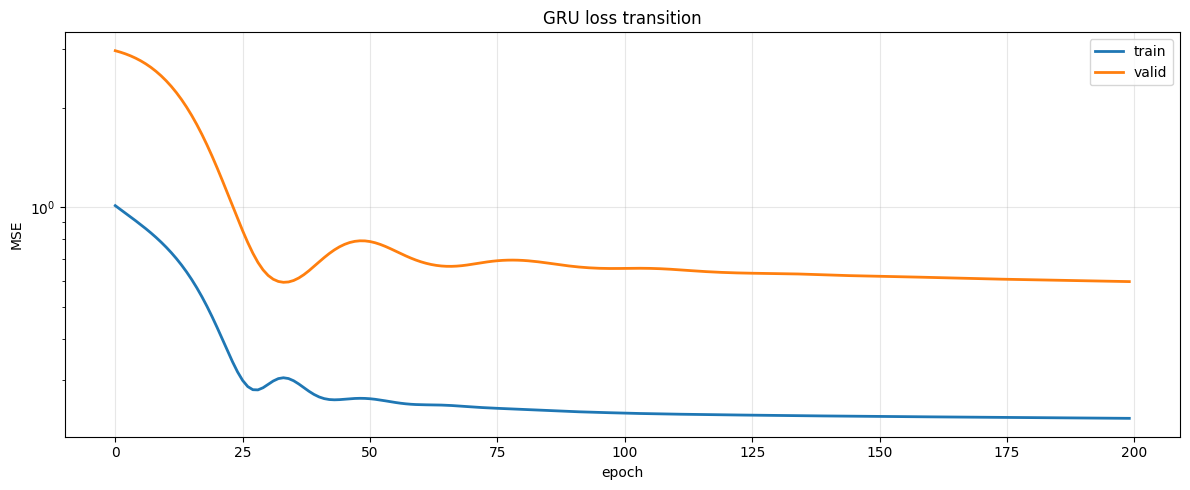

In [43]:
# --- GRU 学習（残差予測）---
gru_model = GRUModel(
    input_size=int(X_train_seq.shape[2]),
    hidden_size=32,
    num_layers=2,
    output_size=2,
    seq_length=int(params.seq_length),
).to(device)

gru_optimizer = optim.Adam(gru_model.parameters(), lr=float(params.gru_lr))
gru_loss_fn = nn.MSELoss()

loss_gru: dict[str, list[float]] = {"train": [], "valid": []}

for epoch in range(1, int(params.epochs_gru) + 1):
    gru_model.train()
    gru_optimizer.zero_grad(set_to_none=True)

    pred_train = gru_model(X_train_seq)
    train_loss = gru_loss_fn(pred_train, y_train_seq)
    train_loss.backward()
    gru_optimizer.step()

    gru_model.eval()
    with torch.no_grad():
        pred_valid = gru_model(X_valid_seq)
        valid_loss = gru_loss_fn(pred_valid, y_valid_seq)

    loss_gru["train"].append(float(train_loss.detach().cpu().item()))
    loss_gru["valid"].append(float(valid_loss.detach().cpu().item()))

    if epoch % 50 == 0 or epoch == 1:
        print(
            f"epoch={epoch:4d} train={loss_gru['train'][-1]:.3e} "
            f"valid={loss_gru['valid'][-1]:.3e}"
        )

# test
gru_model.eval()
with torch.no_grad():
    pred_test = gru_model(X_test_seq)
    test_loss = gru_loss_fn(pred_test, y_test_seq).detach().cpu().item()

print(f"GRU test loss={test_loss:.3e}")

# 損失の遷移
fig_gru, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(loss_gru["train"], label="train", linewidth=2)
ax.plot(loss_gru["valid"], label="valid", linewidth=2)
ax.set_yscale("log")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_title("GRU loss transition")
plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(fig_gru, "gru_loss_transition", result_dir, "GRU 損失遷移")
    save_text_output(
        result_dir, text=f"GRU test loss={test_loss:.6e}\n", title="GRU 評価"
    )


noise_pred_test (physical) mean/std: iL=-4.702e-02/2.477e-02, vC=-1.680e-01/4.566e-02


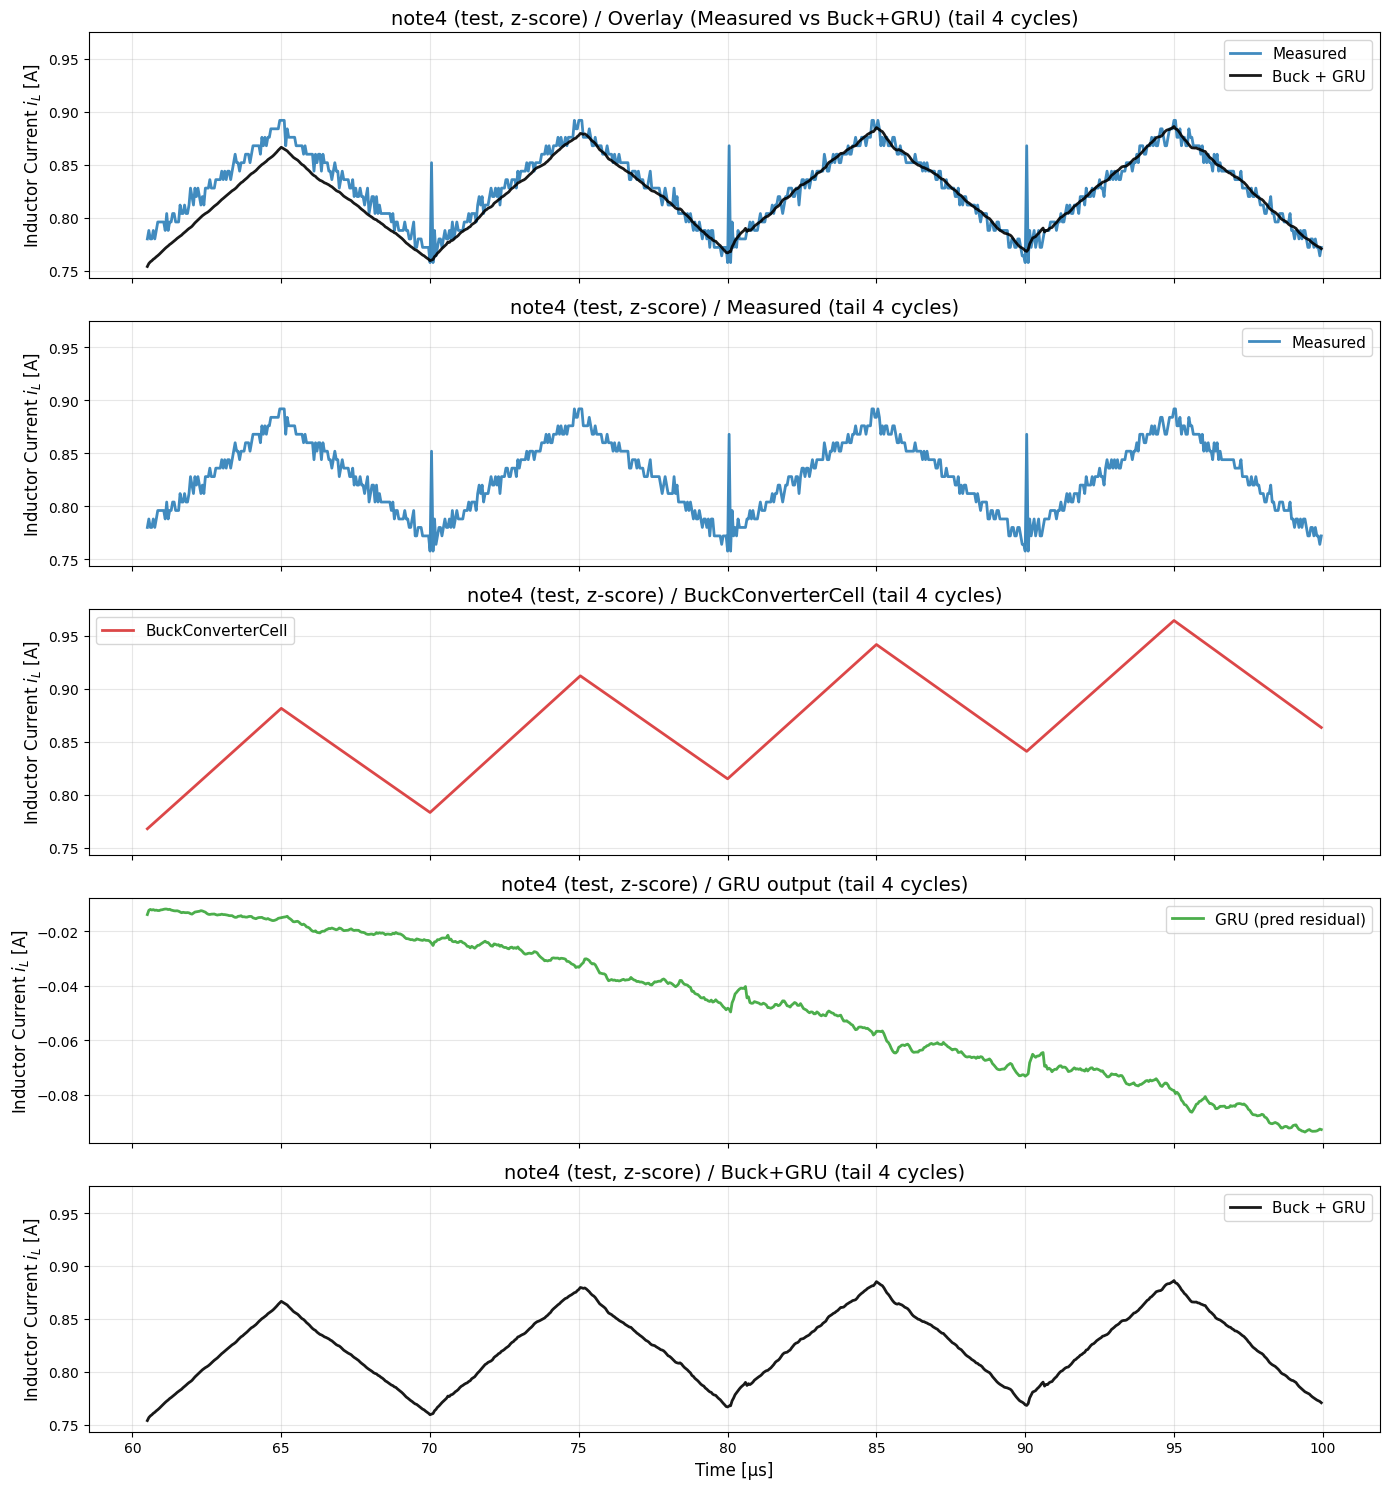

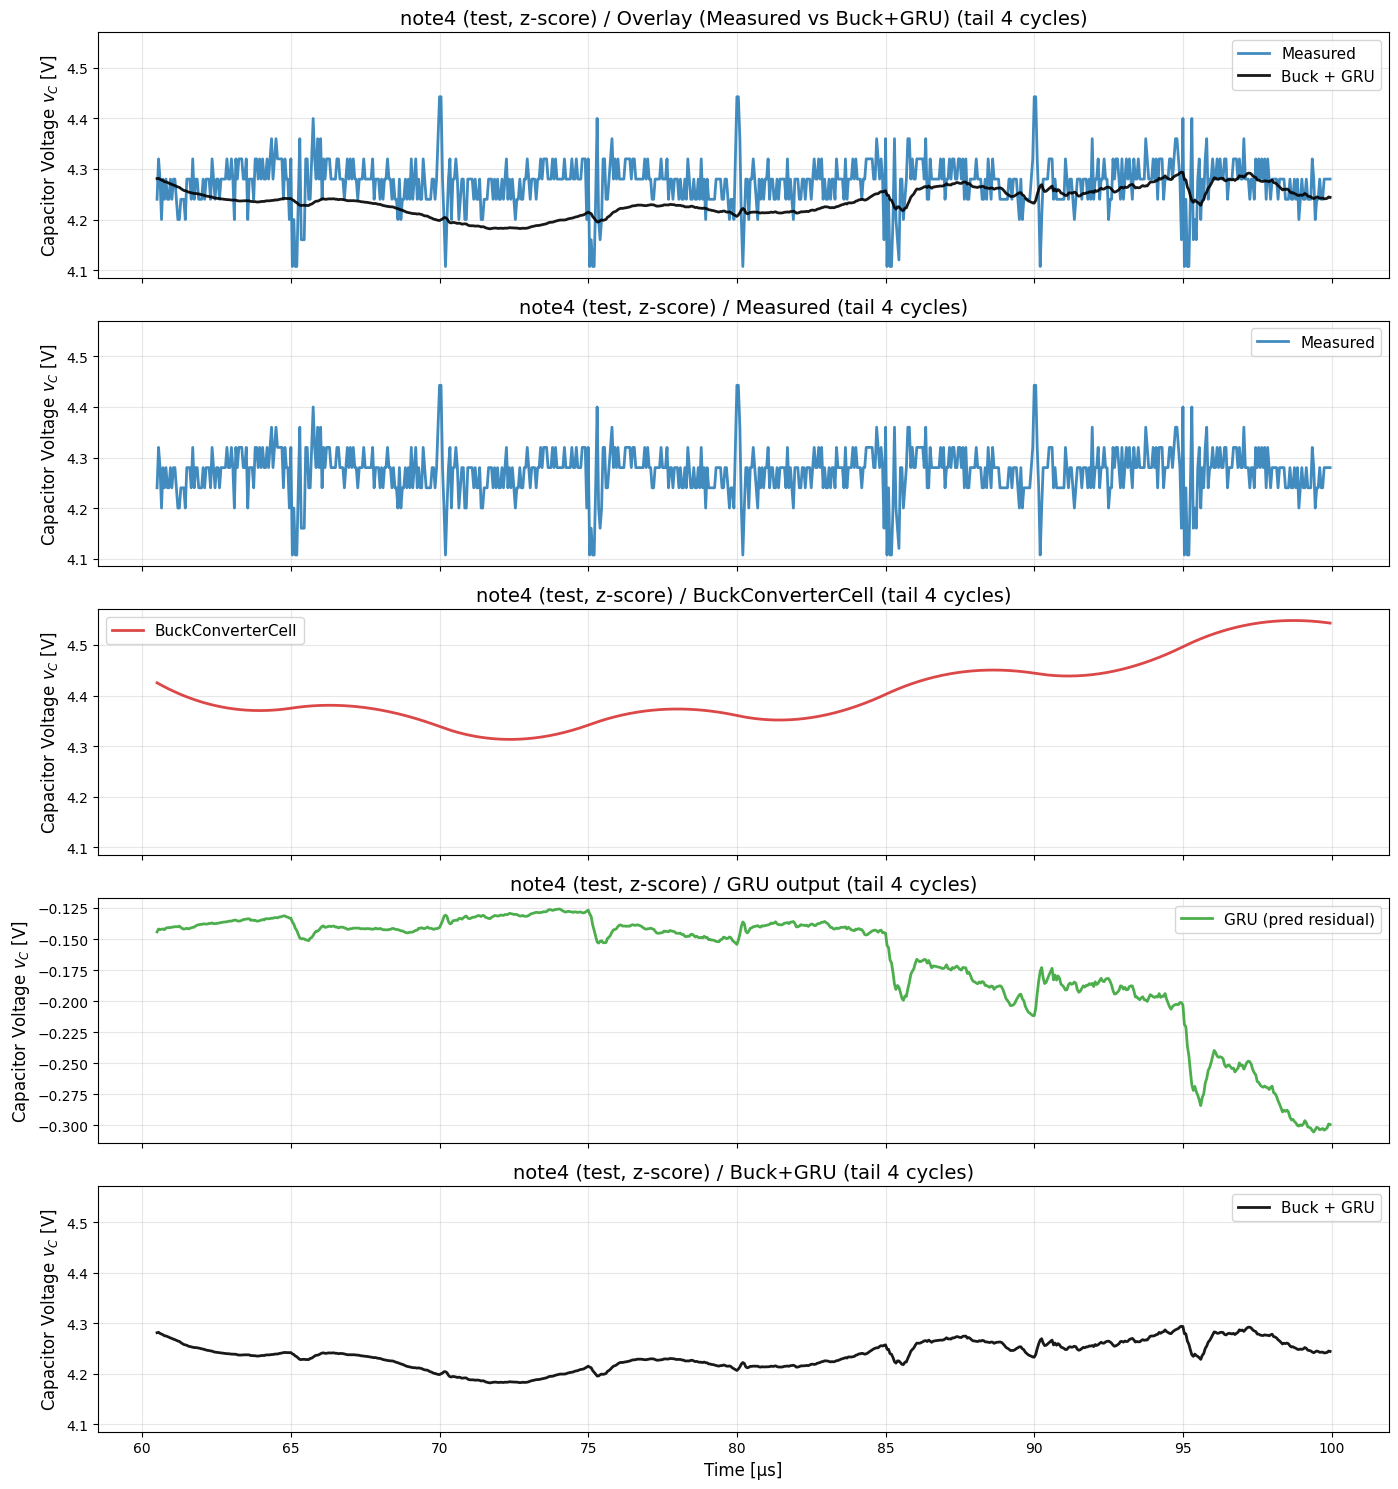

MSE(all) buck=1.318712e-02 -> buck+gru=2.100184e-03
MSE(iL)  buck=2.810512e-03 -> buck+gru=1.559532e-04
MSE(vC)  buck=2.356373e-02 -> buck+gru=4.044415e-03


In [44]:
# --- Buck + GRU 合成（test）---
@torch.no_grad()
def unscale_noise(noise_scaled: torch.Tensor, scales_: Scales) -> torch.Tensor:
    out = torch.empty_like(noise_scaled)
    out[:, 0] = noise_scaled[:, 0] * float(scales_.I_base)
    out[:, 1] = noise_scaled[:, 1] * float(scales_.Vref)
    return out


seq_len: int = int(params.seq_length)

# pred_test は「noise_z（z-score空間）」の予測（shape [N_test-seq_len, 2]）
noise_pred_test_z: torch.Tensor = pred_test

# 復元: z-score -> scaled -> 物理単位
noise_pred_test_scaled: torch.Tensor = destandardize_noise(
    noise_pred_test_z, noise_mean, noise_std
)
noise_pred_test: torch.Tensor = unscale_noise(noise_pred_test_scaled, scales)

# 復元オーダ確認（ざっくり）
noise_pred_test_np = noise_pred_test.detach().cpu().numpy()  # [N_test-seq_len,2]
print(
    "noise_pred_test (physical) mean/std: "
    f"iL={noise_pred_test_np[:, 0].mean():.3e}/{noise_pred_test_np[:, 0].std():.3e}, "
    f"vC={noise_pred_test_np[:, 1].mean():.3e}/{noise_pred_test_np[:, 1].std():.3e}"
)

# steps 系列にそろえる
t_test_steps = t_test_series[:-1]  # [N_test]
h_meas_test_np = h_meas_test_steps.detach().cpu().numpy()  # [N_test,2]
h_buck_test_np = h_buck_test_steps.detach().cpu().numpy()  # [N_test,2]

# 合成できる区間（seq_len 以降）
idx0: int = seq_len
idx1: int = seq_len + int(noise_pred_test_np.shape[0])

t_view = t_test_steps[idx0:idx1]

iL_meas_view = h_meas_test_np[idx0:idx1, 0]
vC_meas_view = h_meas_test_np[idx0:idx1, 1]

iL_buck_view = h_buck_test_np[idx0:idx1, 0]
vC_buck_view = h_buck_test_np[idx0:idx1, 1]

iL_gru_view = noise_pred_test_np[:, 0]
vC_gru_view = noise_pred_test_np[:, 1]

# note3と同様の 4段プロット（Measured / Buck / GRU / Sum）
fig_iL, _, fig_vC, _ = plot_buck_gru_components_tail(
    t=t_view,
    iL_meas=iL_meas_view,
    vC_meas=vC_meas_view,
    iL_buck=iL_buck_view,
    vC_buck=vC_buck_view,
    iL_gru=iL_gru_view,
    vC_gru=vC_gru_view,
    T=float(params.T),
    N_cycles=4.0,
    title="note4 (test, z-score)",
)
plt.show()

if keep_log:
    save_figure_to_log(
        fig_iL,
        "tail4T_iL_meas_buck_gru_sum_zscore",
        result_dir,
        "iL: Measured / Buck / GRU / Buck+GRU（末尾4周期, z-score）",
    )
    save_figure_to_log(
        fig_vC,
        "tail4T_vC_meas_buck_gru_sum_zscore",
        result_dir,
        "vC: Measured / Buck / GRU / Buck+GRU（末尾4周期, z-score）",
    )

# 数値評価（同区間）
h_meas_view = h_meas_test_np[idx0:idx1]
h_buck_view = h_buck_test_np[idx0:idx1]
h_sum_test = np.stack([iL_buck_view + iL_gru_view, vC_buck_view + vC_gru_view], axis=1)

err_buck = h_buck_view - h_meas_view
err_sum = h_sum_test - h_meas_view

mse_buck = float(np.mean(err_buck**2))
mse_sum = float(np.mean(err_sum**2))

mse_buck_iL = float(np.mean(err_buck[:, 0] ** 2))
mse_buck_vC = float(np.mean(err_buck[:, 1] ** 2))
mse_sum_iL = float(np.mean(err_sum[:, 0] ** 2))
mse_sum_vC = float(np.mean(err_sum[:, 1] ** 2))

print(f"MSE(all) buck={mse_buck:.6e} -> buck+gru={mse_sum:.6e}")
print(f"MSE(iL)  buck={mse_buck_iL:.6e} -> buck+gru={mse_sum_iL:.6e}")
print(f"MSE(vC)  buck={mse_buck_vC:.6e} -> buck+gru={mse_sum_vC:.6e}")

if keep_log:
    save_text_output(
        result_dir,
        text=(
            f"MSE(all) buck={mse_buck:.6e}\n"
            f"MSE(all) buck+gru={mse_sum:.6e}\n"
            f"MSE(iL) buck={mse_buck_iL:.6e}\n"
            f"MSE(iL) buck+gru={mse_sum_iL:.6e}\n"
            f"MSE(vC) buck={mse_buck_vC:.6e}\n"
            f"MSE(vC) buck+gru={mse_sum_vC:.6e}\n"
        ),
        title="Buck+GRU 評価(test, z-score)",
    )


In [45]:
# --- ログ用: 回路パラメータを比較しやすい形で保存（推論後に追記）---
if keep_log:
    summary_lines: list[str] = []
    summary_lines.append("【回路パラメータ】")
    summary_lines.append(
        "  真の値: "
        f"L = {float(params.L_true):.6e} [H], "
        f"C = {float(params.C_true):.6e} [F], "
        f"R = {float(params.R_true):.3f} [Ω]"
    )
    summary_lines.append(
        "  初期値: "
        f"L = {float(params.L_init):.6e} [H], "
        f"C = {float(params.C_init):.6e} [F], "
        f"R = {float(params.R_init):.3f} [Ω]"
    )
    summary_lines.append(
        "  推論値: "
        f"L = {float(L_hat):.6e} [H], "
        f"C = {float(C_hat):.6e} [F], "
        f"R = {float(R_hat):.3f} [Ω]"
    )

    save_text_output(result_dir, text="\n".join(summary_lines), title="Summary")
